In [1]:
import requests 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import numpy as np

In [2]:
def get_collector_network(collector_address:str='0x3D0889C3cd2f9f9b53b7132B5e9a0c90D371B9BA', params={}):
    result = requests.get(f'http://localhost:8000/network/{collector_address}/collector-secondary-network')
    result = result.json()
    columns, data = result['columns'], result['data']
    df = pd.DataFrame(data, columns=columns)
    return df 

In [3]:
# _______________________________________
### User input:
nomadd = '0x3D0889C3cd2f9f9b53b7132B5e9a0c90D371B9BA'
nomadd_username = 'nowherenomadd'

fewo = '0x35860583266F6C6caD540EF07B4D36eC0d925916'
fewo_username = 'fewocious'
# _______________________________________
### Set variables here:
user_address = nomadd
user_name = nomadd_username
# _______________________________________

In [4]:
df = get_collector_network(user_address)
df.head(100)

,collector_username,artist_username,weight
0,ghostshoes,thegaloiscxn,15
1,cartoonadvisory,nils_hansen,11
2,louis16art,nils_hansen,11
3,nowherenomadd,osinachi,10
4,nowherenomadd,thegaloiscxn,5
...,...,...,...
95,harvmcm2,blacksneakers,1
96,cartoonadvisory,louis16art,1
97,neuralbricolage,roses,1
98,karafunkel,zakulele,1


In [5]:
g = nx.from_pandas_edgelist(df, "collector_username", "artist_username", ["weight"])
print(g.edges(data=True))

[('ghostshoes', 'thegaloiscxn', {'weight': 2}), ('thegaloiscxn', 'nowherenomadd', {'weight': 5}), ('cartoonadvisory', 'nils_hansen', {'weight': 1}), ('cartoonadvisory', 'louis16art', {'weight': 1}), ('nils_hansen', 'louis16art', {'weight': 1}), ('nils_hansen', 'nowherenomadd', {'weight': 1}), ('nowherenomadd', 'osinachi', {'weight': 10}), ('nowherenomadd', 'faithlove', {'weight': 2}), ('nowherenomadd', 'videodrome', {'weight': 2}), ('nowherenomadd', 'harvmcm2', {'weight': 2}), ('nowherenomadd', 'wallypdf', {'weight': 1}), ('nowherenomadd', 'bingo', {'weight': 1}), ('nowherenomadd', 'hansbenzin', {'weight': 1}), ('nowherenomadd', 'yosnier', {'weight': 1}), ('nowherenomadd', 'thato', {'weight': 1}), ('nowherenomadd', 'madebymetsa', {'weight': 1}), ('nowherenomadd', 'aspalter7', {'weight': 1}), ('nowherenomadd', 'ahmedpartey', {'weight': 1}), ('nowherenomadd', 'txstokes', {'weight': 1}), ('nowherenomadd', 'blacksneakers', {'weight': 1}), ('nowherenomadd', 'sveneberwein', {'weight': 1}), (

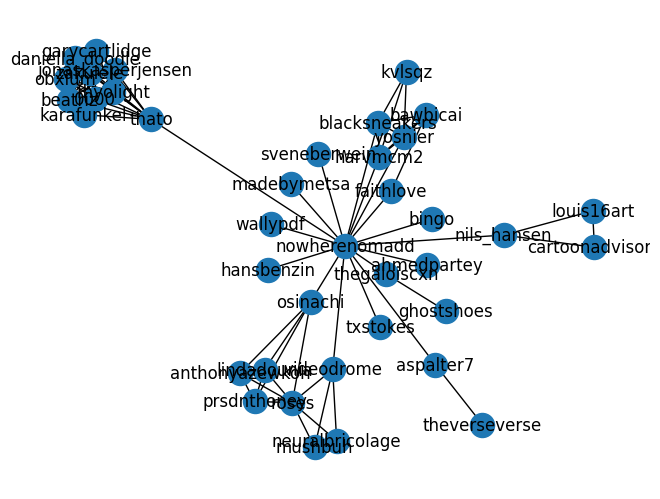

In [6]:
nx.draw(g, with_labels=True)

In [7]:
def create_plotly_visualization(network, sr_user, network_radius=1):
    
    hub_ego = nx.ego_graph(network, sr_user, radius=network_radius)
    pos = nx.spring_layout(hub_ego,iterations=100)
    
    ## with help from https://plotly.com/python/network-graphs/ ##
    
    ###
    #Edges 
    ###
    
    Xv=[pos[k][0] for k in hub_ego.nodes if k != sr_user]
    Yv=[pos[k][1] for k in hub_ego.nodes if k != sr_user]
    Xed=[]
    Yed=[]
    for edge in hub_ego.edges:
        Xed+=[pos[edge[0]][0],pos[edge[1]][0], None]
        Yed+=[pos[edge[0]][1],pos[edge[1]][1], None]
    
    trace3=go.Scatter(x=Xed,
                   y=Yed,
                   mode='lines',
                   line=dict(color='rgb(200,200,200)', width=1),
                   hoverinfo='none'
                   )
    
    colors=[]
    node_iter = []
    for k in hub_ego.nodes:
        if k != sr_user:
            node_iter.append(k)
            try:
                colors.append(nx.degree(hub_ego, weight='weight')[k])
            
            except:
                colors.append(0)
            
    node_text = ["{} :{}".format(x,colors[i]) for i,x in enumerate(node_iter) if x != sr_user] 
    
    profile = "https://superrare.co/{}".format(sr_user)
    title_graph = "SR users connected to {}: <a href='{}'> {}</a>".format(sr_user,profile,profile)
    mode_ = "markers+text"
    
    #Nodes
    trace4=go.Scatter(x=Xv,
                   y=Yv,
                   mode=mode_,
                   name='net',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Viridis',
        reversescale=False,
        color=colors,
        size=8,
        colorbar=dict(
            thickness=15,
            title='Degree',
            xanchor='left',
            titleside='right'
        ),line_width=2),
                   text=["{}".format(x,colors[i]) for i,x in enumerate(node_iter) if x != sr_user] ,
                   hovertext=node_text,
                   hoverinfo='text',
                   textposition="bottom center",
                   )
 
    #SR user node
    trace5=go.Scatter(x=[pos[sr_user][0]],
                      y=[pos[sr_user][1]],
                   mode=mode_,
                   name='net',
                   marker=dict(symbol='circle-dot',
                                 size=20,
                                 color='red',
                                 line=dict(color='rgb(50,50,50)', width=0.5)
                                 ),
                   text=["{}".format(x[0]) for x in nx.degree(hub_ego, weight='weight') if x[0] == sr_user],
                   hovertext=["{}\nDegree:{}".format(x[0],x[1]) for x in nx.degree(hub_ego, weight='weight') if x[0] == sr_user],
                   hoverinfo='text'
                   )
    
    #annot="This networkx.Graph has the ----- layout<br>Code:"+\
    #"<a href='http://nbviewer.ipython.org/gist/empet/07ea33b2e4e0b84193bd'> [2]</a>"
    
    data1=[trace3, trace4, trace5]
    fig1=go.Figure(data=data1,layout=go.Layout(
                    title='<br>{}'.format(title_graph),
                    titlefont_size=16,
                    showlegend=False,
                    #height=1500,
                    #width=2000,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    #fig1['layout']['annotations'][0]['text']=annot
    fig1.update_layout(transition_duration=500)
    
    return fig1

In [10]:
create_plotly_visualization(g, user_name, network_radius=10)